# What's fit.py doing? The fitting procedure in detail

To give further insight into the fitting process in <font color=green>Frankenstein</font> (`frank`) and how you can modify it, here we'll use the code as a library and perform the same fit that's in the [Quickstart](quickstart.rst), just in more detail.

So we'll keep the DSHARP continuum observations of AS 209 ([Andrews et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..41A/abstract)) as the input dataset, and frank will reconstruct the disc's 1D radial brightness profile by nonparametrically fitting the real component of the visibility distribution. 

Specifically frank will perform 4 steps in the fit, which we'll break into distinct calls here (these are the steps taken in `fit.py`): 

1. Read in the data (UVTable) and parse the *.json* parameter file; 

2. Determine the disc geometry (inclination, position angle and phase offset), then deproject the visibilities;

3. Fit the deprojected visibilities with a Gaussian process (~10 s) to yield a brightness profile;

4. Save the results: the brightness profile fit, visibility domain fit, UVtables with the **reprojected** fit and residuals between the input datafile and the reprojected fit, and a figure showing the fit and diagnostics. We'll also supply a CLEAN brightness profile for the disc as well as the synthesized CLEAN beam parameters, allowing frank to compare his fit to the CLEAN fit by:

    - Convolving the fitted frank brightness profile with the synthesized beam to compare to the CLEAN profile and
    
    - Taking the discrete Hankel transform of the CLEAN profile to compare to the frank visibility domain fit.
    
Let's walk through these.

## 1. Read in the data and parameter values

First import the goods. As in the library example in the [Quickstart](quickstart.rst), we're importing the internal class [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) and the `_fit_geometry_gaussian` function used by the internal class [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) directly in order to demonstrate their usage. Just note that `fit.py` uses the wrapper functions `deproject_disc` and `perform_fit` to call these, and more generally uses wrapper functions to do everything that we'll walk through more verbosely here.

In [82]:
%matplotlib inline

import json
import numpy as np
import matplotlib.pyplot as plt

from frank.constants import rad_to_arcsec
from frank.geometry import _fit_geometry_gaussian, SourceGeometry # TODO: _fit_geometry_gaussian
from frank.radial_fitters import FrankFitter
from frank.fit import output_results

Using a UVTable extracted from an MSTable (see [xx](xx.xx) for how to do this) and the default parameter file `default_parameters.json`, let's read both in.

In [21]:
as209_dat = np.load('AS209_continuum.npz')
u, v, vis, weights = [as209_dat[k] for k in ['u', 'v', 'V', 'weights']]

default_parameters = "./../frank/default_parameters.json"
model = json.load(open(default_parameters, 'r'))

## 2. Determinine the disc geometry and deproject the visibilities

Before fitting the radial brightness profile, we need to determine the disc's geometry (inclination, position angle and phase center) in order to deproject the visibilities (frank, fitting in 1D, assumes an axisymmetric source).
To do this we pass an object specifying how the geometry is determined to the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class.

frank has two classes for this: [FixedGeometry](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FixedGeometry) just takes a geometry you provide, while [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) determines the geometry by fitting a 2D Gaussian directly to the visibilities. For the latter you can also choose to provide a known phase center if you just want to fit for the inclination and PA. 

Let's use `_fit_geometry_gaussian`, the function that the [FitGeometryGaussian](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.FitGeometryGaussian) class uses.

In [79]:
inc, PA, dRA, dDec = _fit_geometry_gaussian(u,v,vis,weights)

print('Fitted geometry: inc  = %.2f deg,\n \t\t PA   = %.2f deg,\n \t\t dRA  = %.2f mas,\n \t\t dDec = %.2f mas'
      %(inc, PA, dRA*1e3, dDec*1e3))
      #%(geom.inc, geom.PA, geom.dRA*1e3, geom.dDec*1e3))

Fitted geometry: inc  = -33.93 deg,
 		 PA   = 86.47 deg,
 		 dRA  = 0.86 mas,
 		 dDec = -0.23 mas


xx fix return geom as dict above xx

Cool, these are close to the published values; let's use the published values and deproject the visiblities by them.

In [85]:
geom = SourceGeometry(dRA=1.9e-3, dDec=-2.5e-3, inc=34.97, PA=85.76)

ub, vb, Vb = geom.apply_correction(u,v, vis)

And let's see the effect on the uv-points (not that easily interpretable, but just to show that our correction had an effect).

Text(0.5, 1.0, 'Visibility deprojection')

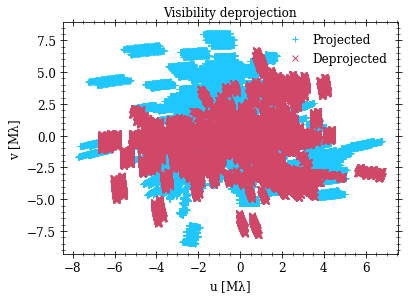

In [90]:
plt.plot(u / 1e6, v / 1e6, '+', c='#1EC8FE', label='Projected')
plt.plot(ub / 1e6, vb / 1e6, 'x', c='#D14768', label='Deprojected')
plt.xlabel('u [M$\lambda$]')
plt.ylabel('v [M$\lambda$]')
plt.legend(loc=0)
plt.title('Visibility deprojection')

### Adding your own geometry fit routine

You can extend frank's geometry fitting capabilities with your own routines by writing a class that inherits from the [SourceGeometry](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry) base class. This base class provides the interface used by frank to deproject the visibilities, but you do need to implement your own [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.fit) method. This method will be called internally by [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) to determine the geometry.

The [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.fit) method should set the attributes `_inc`,  `_PA`, `_dRA`, and `_dDec` -- in respective units of deg, deg, arcsec, arcsec -- that are used by the
[apply_correction()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.apply_correction),
[undo_correction()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.undo_correction),
[deproject()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.deproject),
and
[reproject()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.geometry.SourceGeometry.reproject) methods.

## 3. Fit the deprojected visibilities for the brightness profile

Ok, so we have the deprojected visibilities...let's fit 'em!

Objects used to perform a fit are in the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class. The main parameters are: `Rmax` and `N`, controlling the disc radius out to which the fit is performed and the number of collocation points used in the fit; and the `geometry` object detailed [above](using_frank_as_library.ipynb#2.-Determinine-the-disc-geometry-and-deproject-the-data) xx update xx. The hyperprior is controlled through the parameters `alpha`, `p_0` and `weights_smooth`.

frank performs a fit with the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class' [fit()](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.fit) function. Let's use this class with `Rmax = 1.6"`, `N = 250`, the `geometry` object we generated above using the published values, and we'll pass in the default hyperprior values `alpha = 1.05` and `weights_smooth = 1e-4` just for demonstration (we'll also use the default `p_0 = 1e-15`). Note that we'll only fit the real component of the visibilities, as frank is assuming an axisymmetric source that has zero imaginary component.

In [88]:
Rmax = 1.6
N = 250

FF = FrankFitter(Rmax, N, geometry=geometry, alpha=1.05, weights_smooth=1e-4)

sol = FF.fit(u, v, vis, weights)

## 4. Save the results and generate plots

Once the fit is complete the best fit parameters are returned and stored in the [FrankFitter](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter) class' [MAP_solution](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters.FrankFitter.MAP_solution) attribute. 
The fit is returned as a [_HankelRegressor](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor) object, which provides the posterior [mean](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.mean), [covariance](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.covariance), and [power_spectrum](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.power_spectrum), as well as the fit's radius points [r](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.r) and corresponding frequency points [q](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.q). 

The solution object also provides methods to compute the best fit model's visibilities with [predict](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.predict) and to evaluate its [log_likelihood](https://github.com/discsim/frankenstein/blob/master/docs/_build/html/py_API.html#frankenstein.radial_fitters._HankelRegressor.log_likelihood).

Here's the default figure showing the fitted brightness profile, fitted visibility distribution, power spectrum reconstruction, and a 2D image of the 1D fit swept over $2\pi$. We could also use [CASA](https://casa.nrao.edu) to CLEAN (thereby convolving with the synthesized beam) the `frank` fit image to compare with a CLEAN model image.

In [ ]:
#Note the Hankel transform of the CLEAN profile is low beyond $2\times 10^6 \lambda$ because of beam convolution.
"""
# Plot the CLEAN profile
plt.plot(AS209_profile.r*rad_to_arcsec, AS209_profile.Inu, 'r', label='CLEAN')

# Plot also the predicted visibilities of the CLEAN image
from frank.hankel import DiscreteHankelTransform
dht = DiscreteHankelTransform(Rmax,300)
plot_log_abs(ki, 
             best_fit.predict_deprojected(ki, 
             I=np.interp(dht.r, 
                         AS209_profile.r, 
                         AS209_profile.Inu)),
             c='r', label='CLEAN')
"""             